<a href="https://colab.research.google.com/github/roopsa2004/Projects/blob/main/finalcreditcardfrauddetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/creditcardfraud


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [5]:
# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
)

In [6]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('viridis')

In [7]:
file_path = '/kaggle/input/creditcardfraud/creditcard.csv'
try:

    df = pd.read_csv(file_path)
    print("Dataset 'creditcard.csv' loaded successfully.")
    print(f"Dataset shape: {df.shape}")
    print(df.head())
except FileNotFoundError:

    print("Error: 'creditcard.csv' not found. Please ensure the file is in the correct Kaggle input directory.")
    print("You can download it from Kaggle: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud")
    exit()

Dataset 'creditcard.csv' loaded successfully.
Dataset shape: (284807, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0

In [8]:

print("Explicit Missing Values Check")
missing_values = df.isnull().sum()
print("Count of missing values per column:")
print(missing_values[missing_values > 0])
if missing_values.sum() == 0:
    print("\nNo missing values found across the entire dataset. Data is clean regarding nulls.")
else:
    print(f"\nTotal missing values in the dataset: {missing_values.sum()}")

Explicit Missing Values Check
Count of missing values per column:
Series([], dtype: int64)

No missing values found across the entire dataset. Data is clean regarding nulls.


Normalized Class Distribution:
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

Absolute Class Distribution:
Class
0    284315
1       492
Name: count, dtype: int64


<ipython-input-9-90b113891eba>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=df, palette='coolwarm')


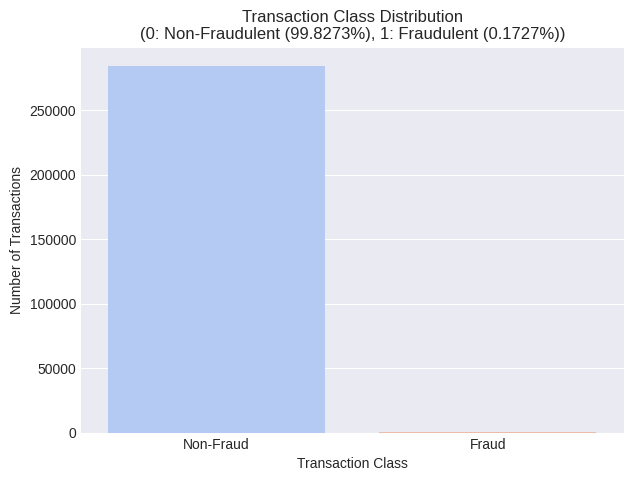

In [9]:

class_distribution = df['Class'].value_counts(normalize=True)
print("Normalized Class Distribution:")
print(class_distribution)

print("\nAbsolute Class Distribution:")
print(df['Class'].value_counts())

plt.figure(figsize=(7, 5))
sns.countplot(x='Class', data=df, palette='coolwarm')
plt.title(f"Transaction Class Distribution\n(0: Non-Fraudulent ({class_distribution[0]*100:.4f}%), 1: Fraudulent ({class_distribution[1]*100:.4f}%))")
plt.xlabel("Transaction Class")
plt.ylabel("Number of Transactions")
plt.xticks(ticks=[0, 1], labels=['Non-Fraud', 'Fraud'])
plt.show()


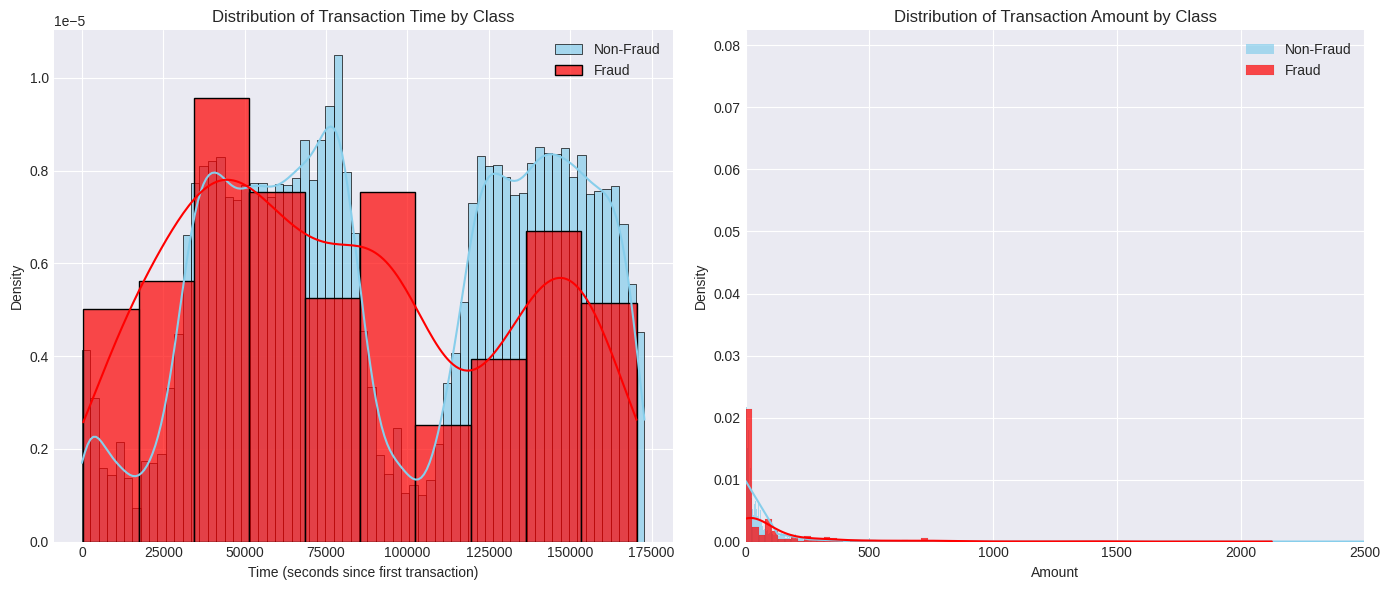

In [10]:

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df[df['Class'] == 0]['Time'], kde=True, color='skyblue', label='Non-Fraud', stat='density', alpha=0.7)
sns.histplot(df[df['Class'] == 1]['Time'], kde=True, color='red', label='Fraud', stat='density', alpha=0.7)
plt.title('Distribution of Transaction Time by Class')
plt.xlabel('Time (seconds since first transaction)')
plt.ylabel('Density')
plt.legend()
plt.subplot(1, 2, 2)
sns.histplot(df[df['Class'] == 0]['Amount'], kde=True, color='skyblue', label='Non-Fraud', stat='density', alpha=0.7)
sns.histplot(df[df['Class'] == 1]['Amount'], kde=True, color='red', label='Fraud', stat='density', alpha=0.7)
plt.title('Distribution of Transaction Amount by Class')
plt.xlabel('Amount')
plt.ylabel('Density')
plt.xlim(0, 2500)
plt.legend()
plt.tight_layout()
plt.show()

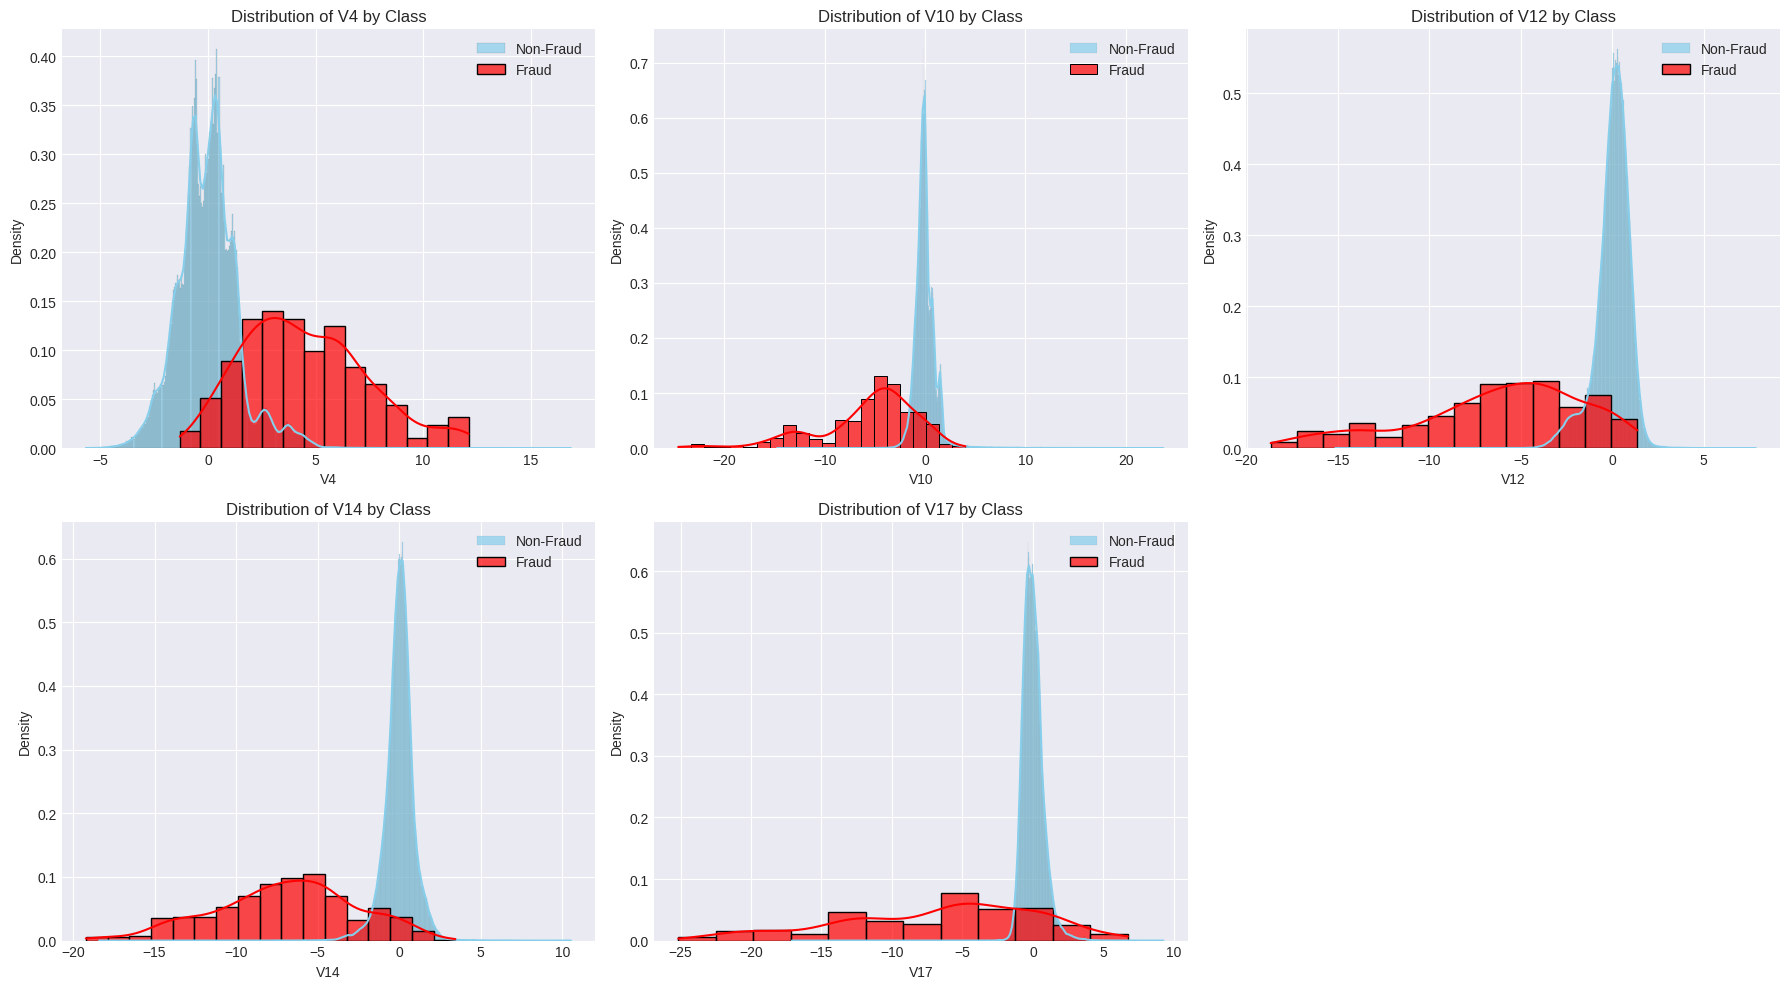

In [11]:

v_features_to_plot = ['V4', 'V10', 'V12', 'V14', 'V17']
plt.figure(figsize=(18, 10))
for i, feature in enumerate(v_features_to_plot):
  plt.subplot(2,3,i+1)
  sns.histplot(df[df['Class'] == 0][feature], kde=True, color='skyblue', label='Non-Fraud', stat='density', alpha=0.7)
  sns.histplot(df[df['Class'] == 1][feature], kde=True, color='red', label='Fraud', stat='density', alpha=0.7)
  plt.title(f'Distribution of {feature} by Class')
  plt.xlabel(feature)
  plt.ylabel('Density')
  plt.legend()
plt.tight_layout()
plt.show()

In [12]:

X = df.drop('Class', axis=1)
y=df['Class']
print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print("\nFirst 5 rows of X:")
print(X.head())
print("\nFirst 5 values of y:")
print(y.head())


Features (X) shape: (284807, 30)
Target (y) shape: (284807,)

First 5 rows of X:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V20       V21       V22       V23       V24  \
0  0.098698  0.363787  ...  0.251412 -0.018307  0.277838 -0.110474  0.066928   
1  0.085102 -0.255425  ... -0.069083 -0.225775 -0.638672  0.101288 -0.339846   
2  0.247676 -1.514654  ...  0.524980  0.247998  0.771679  0.909412 -0.689281   
3  0.377436 -1.387024  ... -0.208038 -0.108300  0.005274 -0.190321 -1.175575   
4 -0.270533  0.817739  ...  0.40

In [13]:
print("\n Features for Scaling ")
numerical_features_to_scale = ['Time', 'Amount']
features_not_to_scale = [col for col in X.columns if col.startswith('V')]

print(f"Features to scale: {numerical_features_to_scale}")
print(f"Features not to scale (PCA-transformed): {features_not_to_scale[:5]} ... {features_not_to_scale[-5:]}")


 Features for Scaling 
Features to scale: ['Time', 'Amount']
Features not to scale (PCA-transformed): ['V1', 'V2', 'V3', 'V4', 'V5'] ... ['V24', 'V25', 'V26', 'V27', 'V28']


In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaler', StandardScaler(), numerical_features_to_scale)
    ],
    remainder='passthrough'
)


In [15]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("StratifiedKFold (5-fold) initialized for robust cross-validation.")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set features (X_train) shape: {X_train.shape}")
print(f"Training set target (y_train) shape: {y_train.shape}")
print(f"Test set features (X_test) shape: {X_test.shape}")
print(f"Test set target (y_test) shape: {y_test.shape}")
print("\nClass distribution in Training set:")
print(y_train.value_counts(normalize=True))
print("Class distribution in Test set:")
print(y_test.value_counts(normalize=True))
print(f"\nFraudulent cases in Training set: {y_train.sum()}")
print(f"Fraudulent cases in Test set: {y_test.sum()}")


StratifiedKFold (5-fold) initialized for robust cross-validation.

Training set features (X_train) shape: (227845, 30)
Training set target (y_train) shape: (227845,)
Test set features (X_test) shape: (56962, 30)
Test set target (y_test) shape: (56962,)

Class distribution in Training set:
Class
0    0.998271
1    0.001729
Name: proportion, dtype: float64
Class distribution in Test set:
Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64

Fraudulent cases in Training set: 394
Fraudulent cases in Test set: 98


In [16]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]))
}
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.01, 0.1, 1, 10]
    },
    'Decision Tree': {
        'classifier__max_depth': [3, 5, 7, None],
        'classifier__min_samples_leaf': [1, 5, 10]
    },
    'Random Forest': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [5, 10],
        'classifier__min_samples_leaf': [5, 10]
    },
     'XGBoost': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [3, 5],
        'classifier__learning_rate': [0.01, 0.1]
    }
}
print("Hyperparameter grids defined for each model.")

results = {}


Hyperparameter grids defined for each model.



===== Training and Tuning: Logistic Regression =====
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters for Logistic Regression: {'classifier__C': 0.01}

Performance for Logistic Regression on Test Set:
  Accuracy (misleading for imbalance): 0.9758
  Precision (Fraud Class): 0.0616
  Recall (Fraud Class): 0.9184
  F1-Score (Fraud Class): 0.1155
  ROC AUC Score: 0.9725
  Confusion Matrix:


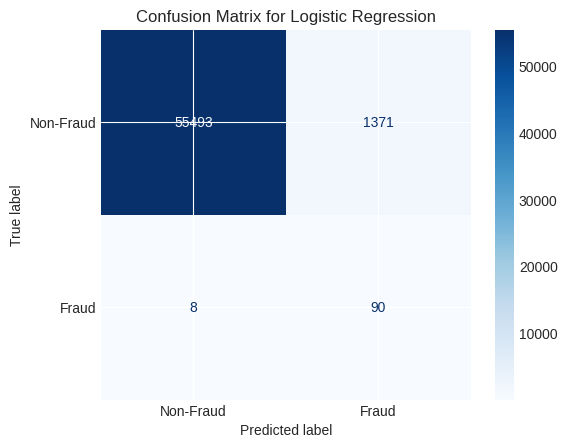


--- Coefficients for Logistic Regression (Logistic Regression) ---
               Feature  Coefficient
5        remainder__V4     0.921443
1   num_scaler__Amount     0.825811
23      remainder__V22     0.602663
29      remainder__V28     0.445728
6        remainder__V5     0.405913
2        remainder__V1     0.402664
12      remainder__V11     0.317884
22      remainder__V21     0.186667
3        remainder__V2     0.063334
20      remainder__V19     0.038436

Features with most negative coefficients:
             Feature  Coefficient
27    remainder__V26    -0.337347
0   num_scaler__Time    -0.365706
14    remainder__V13    -0.410455
9      remainder__V8    -0.471115
21    remainder__V20    -0.559016
18    remainder__V17    -0.605658
17    remainder__V16    -0.760113
13    remainder__V12    -0.767678
11    remainder__V10    -0.894750
15    remainder__V14    -1.132370

===== Training and Tuning: Decision Tree =====
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best param

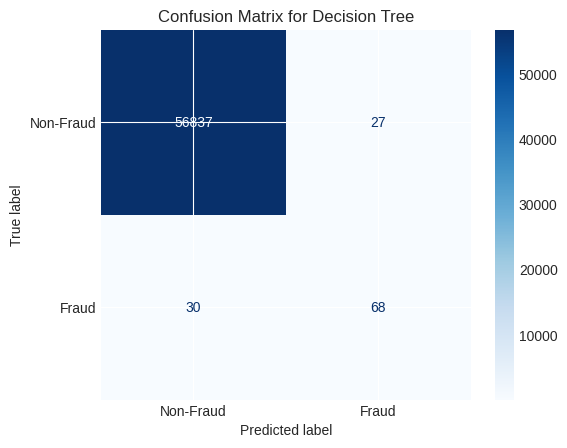


--- Feature Importance for Decision Tree ---
           Feature      Importance
10   remainder__V9   remainder__V9
9    remainder__V8   remainder__V8
8    remainder__V7   remainder__V7
7    remainder__V6   remainder__V6
6    remainder__V5   remainder__V5
5    remainder__V4   remainder__V4
4    remainder__V3   remainder__V3
29  remainder__V28  remainder__V28
28  remainder__V27  remainder__V27
27  remainder__V26  remainder__V26


<ipython-input-17-3ac342466c17>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis')


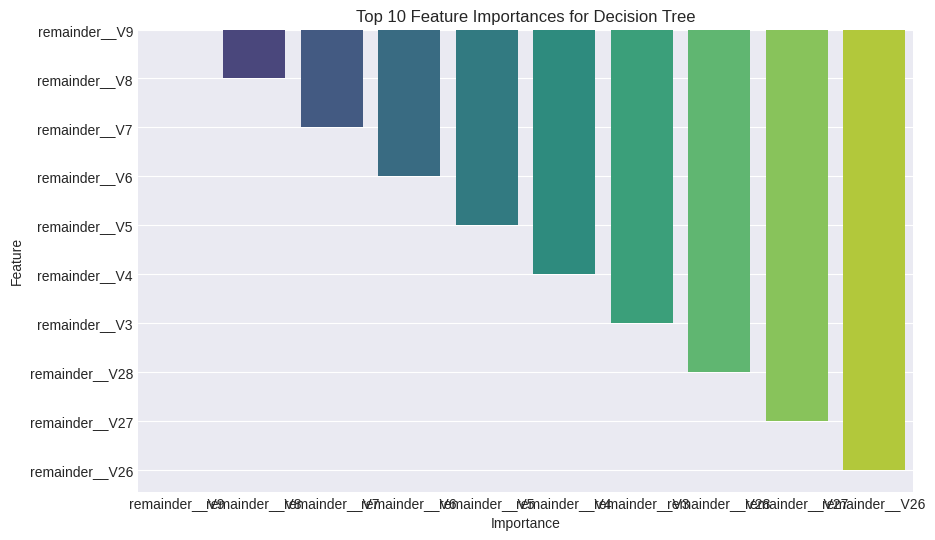


===== Training and Tuning: Random Forest =====
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters for Random Forest: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 5, 'classifier__n_estimators': 100}

Performance for Random Forest on Test Set:
  Accuracy (misleading for imbalance): 0.9993
  Precision (Fraud Class): 0.7593
  Recall (Fraud Class): 0.8367
  F1-Score (Fraud Class): 0.7961
  ROC AUC Score: 0.9746
  Confusion Matrix:


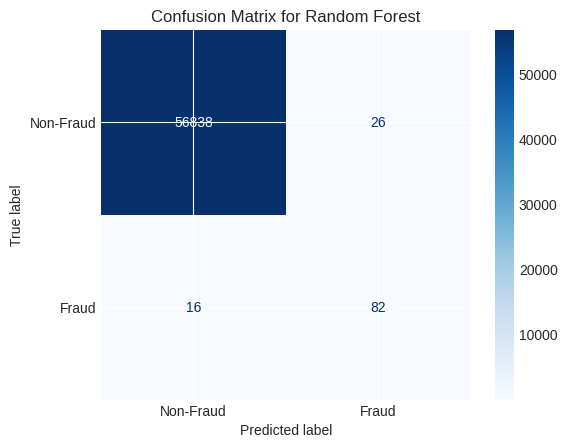


--- Feature Importance for Random Forest ---
           Feature      Importance
10   remainder__V9   remainder__V9
9    remainder__V8   remainder__V8
8    remainder__V7   remainder__V7
7    remainder__V6   remainder__V6
6    remainder__V5   remainder__V5
5    remainder__V4   remainder__V4
4    remainder__V3   remainder__V3
29  remainder__V28  remainder__V28
28  remainder__V27  remainder__V27
27  remainder__V26  remainder__V26


<ipython-input-17-3ac342466c17>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis')


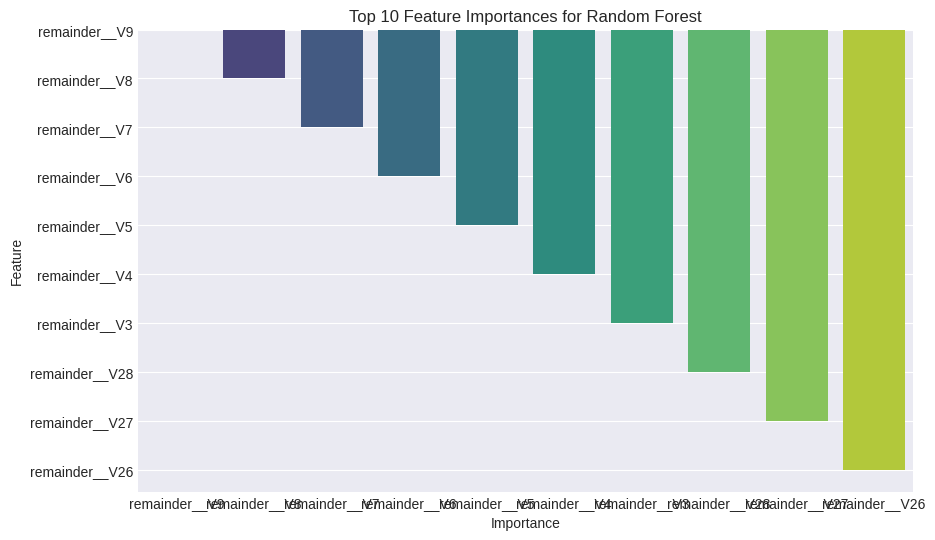


===== Training and Tuning: XGBoost =====
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:47:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters for XGBoost: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200}

Performance for XGBoost on Test Set:
  Accuracy (misleading for imbalance): 0.9994
  Precision (Fraud Class): 0.8367
  Recall (Fraud Class): 0.8367
  F1-Score (Fraud Class): 0.8367
  ROC AUC Score: 0.9778
  Confusion Matrix:


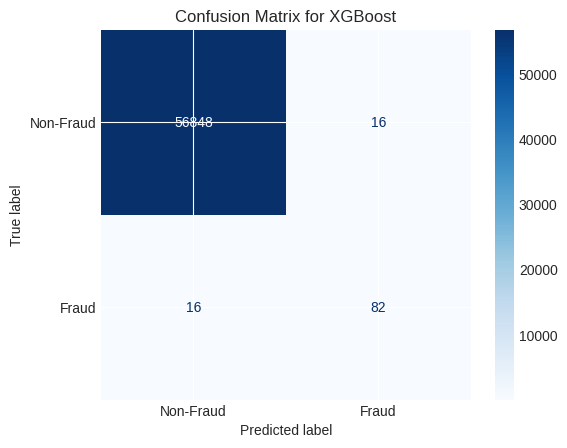


--- Feature Importance for XGBoost ---
           Feature      Importance
10   remainder__V9   remainder__V9
9    remainder__V8   remainder__V8
8    remainder__V7   remainder__V7
7    remainder__V6   remainder__V6
6    remainder__V5   remainder__V5
5    remainder__V4   remainder__V4
4    remainder__V3   remainder__V3
29  remainder__V28  remainder__V28
28  remainder__V27  remainder__V27
27  remainder__V26  remainder__V26


<ipython-input-17-3ac342466c17>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis')


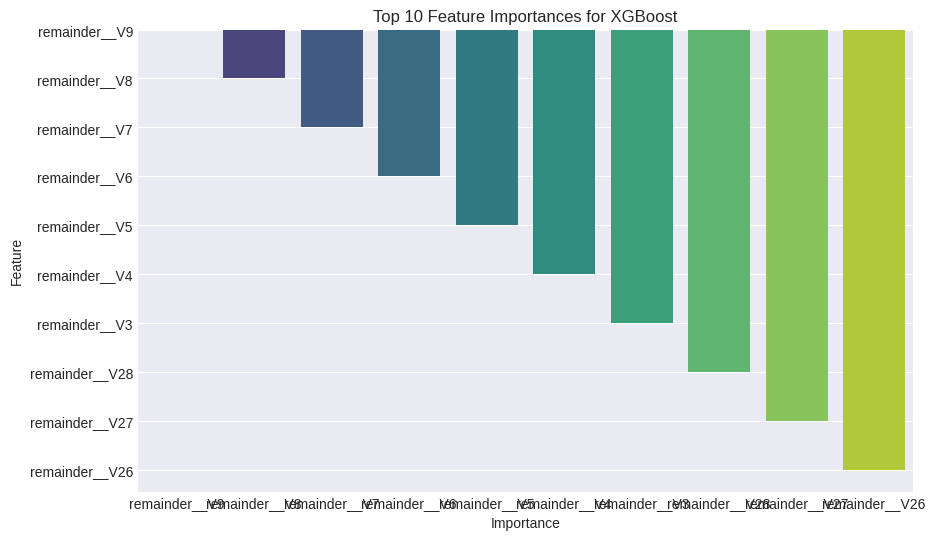

In [17]:
for model_name, model in models.items():
    print(f"\n===== Training and Tuning: {model_name} =====")
    full_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('classifier', model)])
    grid_search = GridSearchCV(full_pipeline, param_grids[model_name], cv=skf, scoring='f1', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    results[model_name] = {'best_model': best_model, 'best_params': grid_search.best_params_}

    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    conf_matrix = confusion_matrix(y_test, y_pred)

    results[model_name].update({
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
         'confusion_matrix': conf_matrix
    })

    print(f"\nPerformance for {model_name} on Test Set:")
    print(f"  Accuracy (misleading for imbalance): {accuracy:.4f}")
    print(f"  Precision (Fraud Class): {precision:.4f}")
    print(f"  Recall (Fraud Class): {recall:.4f}")
    print(f"  F1-Score (Fraud Class): {f1:.4f}")
    print(f"  ROC AUC Score: {roc_auc:.4f}")
    print("  Confusion Matrix:")
    cmd_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Non-Fraud', 'Fraud'])
    cmd_display.plot(cmap='Blues', values_format='d') # 'd' for integer format
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
        print(f"\n--- Feature Importance for {model_name} ---")
        feature_importances = best_model.named_steps['classifier'].feature_importances_preprocessed_feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
        importance_df = pd.DataFrame({
            'Feature': preprocessed_feature_names,
            'Importance': feature_importances
        }).sort_values(by='Importance', ascending=False)

        print(importance_df.head(10))

        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis')
        plt.title(f'Top 10 Feature Importances for {model_name}')
        plt.show()
    elif hasattr(best_model.named_steps['classifier'], 'coef_'):
        print(f"\n--- Coefficients for {model_name} (Logistic Regression) ---")
        coefficients = best_model.named_steps['classifier'].coef_[0] # For binary classification, coef_ is 2D
        preprocessed_feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

        coef_df = pd.DataFrame({
            'Feature': preprocessed_feature_names,
            'Coefficient': coefficients
            }).sort_values(by='Coefficient', ascending=False)
        print(coef_df.head(10))
        print("\nFeatures with most negative coefficients:")
        print(coef_df.tail(10))

In [18]:
summary_data = []
for model_name, metrics in results.items():
   if 'accuracy' in metrics:
        summary_data.append({
            'Model': model_name,
            'Accuracy': metrics['accuracy'],
            'Precision (Fraud)': metrics['precision'],
            'Recall (Fraud)': metrics['recall'],
            'F1-Score (Fraud)': metrics['f1_score'],
            'ROC AUC': metrics['roc_auc']
        })
performance_summary_df = pd.DataFrame(summary_data).set_index('Model')
print(performance_summary_df.round(4))
best_f1_model_name = performance_summary_df['F1-Score (Fraud)'].idxmax()
print(f"\nBest Model based on F1-Score: **{best_f1_model_name}**")


                     Accuracy  Precision (Fraud)  Recall (Fraud)  \
Model                                                              
Logistic Regression    0.9758             0.0616          0.9184   
Decision Tree          0.9990             0.7158          0.6939   
Random Forest          0.9993             0.7593          0.8367   
XGBoost                0.9994             0.8367          0.8367   

                     F1-Score (Fraud)  ROC AUC  
Model                                           
Logistic Regression            0.1155   0.9725  
Decision Tree                  0.7047   0.8467  
Random Forest                  0.7961   0.9746  
XGBoost                        0.8367   0.9778  

Best Model based on F1-Score: **XGBoost**
